# Deep Convolutional Neural Networks with PyTorch

In [1]:
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import pathlib
from tqdm import tqdm

**How to accelerate deep learning training using PyTorch with CUDA.**

Why use GPU over CPU for Deep Learning?
There are two basic neural network training approaches. We might train either on a central processing unit (CPU) or graphics processing unit (GPU).

As you might know, the most computationally demanding piece in a neural network is multiple matrix multiplications. In general, if we start training on a CPU, each operation will be done one after the other. On the contrary, when using a GPU, all the operations will be done at the same time.

https://cnvrg.io/pytorch-cuda/

So first, let's check if cuda is available to increase the computing power using GPU:

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Import Train and Test data

The following cell is just a draft to see how we can import data from google drive to colab. We store the relative paths of the files in different lists for each category we want to classify. 

In [2]:
directory= "/content/drive/MyDrive/Kaggle-Datasets/Dog-vs-Cat/dataset"
cat_test= "test_set/cats"
dog_test= "test_set/dogs"
cat_train= "training_set/cats"
dog_train= "training_set/dogs"

cat_test_file_path=os.path.join(directory,cat_test)
cat_test_files=[os.path.join(cat_test_file_path,file) for file in  os.listdir(cat_test_file_path) if file.endswith(".jpg")]
cat_train_file_path=os.path.join(directory,cat_train)
cat_train_files=[os.path.join(cat_train_file_path,file) for file in  os.listdir(cat_train_file_path) if file.endswith(".jpg")]
dog_test_file_path=os.path.join(directory,dog_test)
dog_test_files=[os.path.join(dog_test_file_path,file) for file in  os.listdir(dog_test_file_path) if file.endswith(".jpg")]
dog_train_file_path=os.path.join(directory,dog_train)
dog_train_files=[os.path.join(dog_train_file_path,file) for file in  os.listdir(dog_train_file_path) if file.endswith(".jpg")]

print("Number of cat images in train dataset:", len(cat_train_files), ", in test dataset:", len(cat_test_files))
print("Number of dog images in train dataset:", len(dog_train_files), ", in test dataset:", len(dog_test_files))

Number of cat images in train dataset: 4000 , in test dataset: 1000
Number of dog images in train dataset: 4000 , in test dataset: 1000


For example, let's see the first image representing a cat in test files:

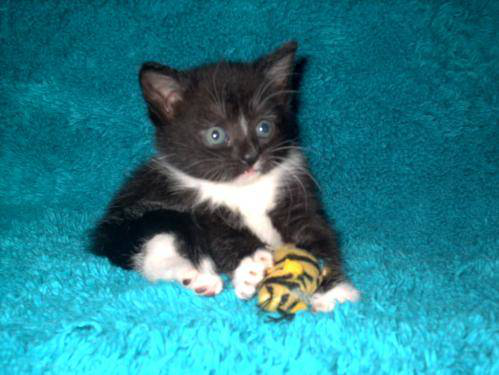

In [3]:
Image.open(cat_test_files[0])

The cell below is about the creation of a dataset class, required to use a dataloader object which allows us to manipulate mini-batches during the training and testing process of the neural network (Basically we will create 2 instances of this class, one for training and one for testing):

In [85]:
class CreateDataset(Dataset):
  def __init__(self, transform = None, train = True):
    directory= "/content/drive/MyDrive/Kaggle-Datasets/Dog-vs-Cat/dataset"
    cat_test= "test_set/cats"
    dog_test= "test_set/dogs"
    cat_train= "training_set/cats"
    dog_train= "training_set/dogs"

    cat_test_file_path=os.path.join(directory,cat_test)
    cat_test_files=[os.path.join(cat_test_file_path,file) for file in  os.listdir(cat_test_file_path) if file.endswith(".jpg")]
    cat_train_file_path=os.path.join(directory,cat_train)
    cat_train_files=[os.path.join(cat_train_file_path,file) for file in  os.listdir(cat_train_file_path) if file.endswith(".jpg")]
    dog_test_file_path=os.path.join(directory,dog_test)
    dog_test_files=[os.path.join(dog_test_file_path,file) for file in  os.listdir(dog_test_file_path) if file.endswith(".jpg")]
    dog_train_file_path=os.path.join(directory,dog_train)
    dog_train_files=[os.path.join(dog_train_file_path,file) for file in  os.listdir(dog_train_file_path) if file.endswith(".jpg")]

    self.transform = transform

    if train == True:
      self.all_files = dog_train_files + cat_train_files
      self.Y = torch.zeros(len(dog_train_files)+len(cat_train_files)).type(torch.LongTensor)
      self.Y[0:len(dog_train_files)] = 1
      self.Y[len(dog_train_files):] = 0
    else:
      self.all_files = dog_test_files + cat_test_files
      self.Y = torch.zeros(len(dog_test_files)+len(cat_test_files)).type(torch.LongTensor)
      self.Y[0:len(dog_test_files)] = 1
      self.Y[len(dog_test_files):] = 0

  def __len__(self):
    return len(self.all_files)
  
  def __getitem__(self, idx):
    image = Image.open(self.all_files[idx])
    y = self.Y[idx]
    if self.transform:
      image = self.transform(image)
    return image, y


We apply some modifications to the images in our datasets using a transforms.Compose method. We transform the images to Tensor in order to feed and train the model, one image being a multidimensionnal tensor of dimension [C,H,W] (C being the number of channels - 3 for RGB images, H for the image height, and W for the width).

Resize makes sure that all the images have a fixed dimension of 64x64.

RandomHorizontalFlip is a data augmentation technique and it means there is 50% chance that the image is flipped along the horizontal axis.

Finally, Normalize allows us to change the range of all the values in the multidimensionnal tensors, from [0;1] (which are the scaled values of the pixels (from 0 to 255)) to [-1;1].

In [86]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((64,64)),
                                transforms.RandomHorizontalFlip(0.5),
                                transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                                [0.5,0.5,0.5])])
train_dataset = CreateDataset(transform=transform)
test_dataset = CreateDataset(transform=transform, train=False)
print(train_dataset[0][0].shape)
print(len(train_dataset))
print(test_dataset[0][0].shape)
print(len(test_dataset))

torch.Size([3, 64, 64])
8000
torch.Size([3, 64, 64])
2000


## Create the Convolutional Model

In [7]:
class NeuralNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, padding=1, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(num_features=12) 
    self.max1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(in_channels=12, out_channels=10, padding=1, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=10, out_channels=12, padding=1, kernel_size=3)
    self.bn3=nn.BatchNorm2d(num_features=12)
    self.fc1 = nn.Linear(in_features=12*32*32,out_features=2)
    
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = torch.relu(x)
    x = self.max1(x)
    x = self.conv2(x)
    x = torch.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)
    x = torch.relu(x)
    x = self.fc1(x.reshape((x.shape[0],-1)))
    return x

## Train and Test the model

In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

model = NeuralNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 1
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(epochs):
  model.train()
  total_loss = 0
  correct = 0
  for x, y in tqdm(train_loader):
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    z = model(x)
    _, yhat = torch.max(z, 1)
    loss = criterion(z, y)
    loss.backward()
    total_loss += loss.item()
    optimizer.step()
    correct += torch.sum(yhat == y).item()
    
  train_loss.append(total_loss)
  train_accuracy.append(correct/len(train_dataset))

  print("Train Loss:", train_loss[-1], "Train Accuracy:", train_accuracy[-1])

  model.eval()
  total_loss = 0
  correct = 0

  for x, y in tqdm(test_loader):
    x = x.to(device)
    y = y.to(device)
    z = model(x)
    _, yhat = torch.max(z, 1)
    loss = criterion(z, y)
    total_loss += loss.item()
    correct += torch.sum(yhat == y).item()
  test_loss.append(total_loss)
  test_accuracy.append(correct/len(test_dataset))

  print("Test Loss:", test_loss[-1], "Test Accuracy:", test_accuracy[-1])

  if test_accuracy[-1] >= max(test_accuracy):
    data = {"model_state": model.state_dict()}
    torch.save(data, "data.pth")

## Load and Try the best saved model

In [5]:
with open('data.pth', 'rb') as f:
  data = torch.load(f)

In [11]:
new_model = NeuralNet()
new_model.load_state_dict(data['model_state'])

<All keys matched successfully>

The best state dictionnary has been set up, we can re-use this model to make predictions!

First, let's take the first image of test dataset

In [17]:
test_dataset[0][1]

tensor(1)

We see the ground truth is 1 which means that the image represents a dog

Now let's make a prediction on this first image of test dataset:

In [87]:
z = new_model(test_dataset[0][0].reshape((1,3,64,64)))
print(z)
_, yhat = torch.max(z, 1)
print(yhat)

tensor([[-1.2742,  0.7666]], grad_fn=<AddmmBackward>)
tensor([1])


The prediction is correct, the model understands the image represents a dog!

Of course, we can increase the accuracy of our model by increasing the number of epochs, which means a longer training. We can also add more convolutional layers, it will produce more computations so make sure to use a GPU to reduce the global computation time.